
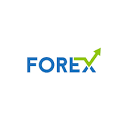
# Currency Predictor 

**Members:**
- Rishank Karkera
- Atharv Mhatre
- Nivedita Gadade
- Preet Chaudhari


In [211]:
! pip install prophet

In [250]:
# library import
import requests
import datetime
from io import StringIO
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot

## 1. Data exploration

### Configure currencies and dates to apply prediction

In [213]:
# Enter start & end dates
start_date = datetime.date(2021, 12, 1)
end_date = datetime.date(2022, 12, 1)

# Enter source & target currencies
source_currency = "USD"
target_currency = "INR"

### Gather FX rate data for above params from API and pre-process it

In [214]:
# functions for getting fx data from api
API_URL = "https://marketdata.tradermade.com/api/v1"

def get_api_key():
    return open("api.key", mode='r').read()


def send_api_request(url):
    headers = {'Accept': 'application/json'}
    return requests.get(url=url, headers=headers)


def get_fx_data(source_currency, target_currency, start_date, end_date):
    api_key = get_api_key()
    url = f"{API_URL}/timeseries?currency={source_currency}{target_currency}&api_key={api_key}&start_date={start_date}&end_date={end_date}&format=csv"
    return send_api_request(url).text
 

def get_currency_df(source_currency, target_currency, start_date, end_date):
    currency_rates = get_fx_data(source_currency, target_currency, start_date, end_date)
    return pd.read_csv(StringIO(currency_rates), sep=",")


currency_df = get_currency_df(source_currency, target_currency, start_date, end_date)
currency_df

,date,open,high,low,close
0,2021-12-01,74.97124,75.10881,74.77473,75.00900
1,2021-12-02,75.01320,75.26833,74.86407,74.97580
2,2021-12-03,74.97530,75.48080,74.93500,75.32664
3,2021-12-06,75.24978,75.48105,75.15823,75.39134
4,2021-12-07,75.37476,75.49620,75.25400,75.43165
...,...,...,...,...,...
257,2022-11-25,81.63402,81.74599,81.40804,81.69398
258,2022-11-28,81.69398,81.83900,81.58302,81.63102
259,2022-11-29,81.63102,81.74899,81.51003,81.61402
260,2022-11-30,81.63198,81.72899,81.23106,81.36195


### Explore data, pattern for the provided exchange rate & dates

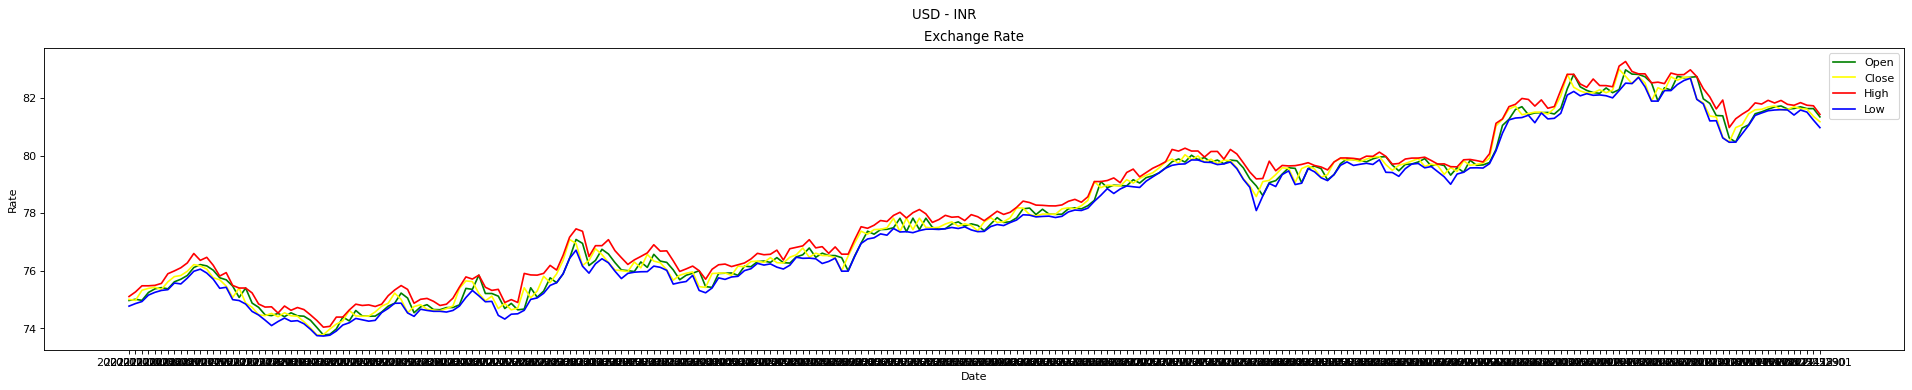

           open      high       low     close
open   1.000000  0.997475  0.997833  0.994642
high   0.997475  1.000000  0.997256  0.996933
low    0.997833  0.997256  1.000000  0.997869
close  0.994642  0.996933  0.997869  1.000000


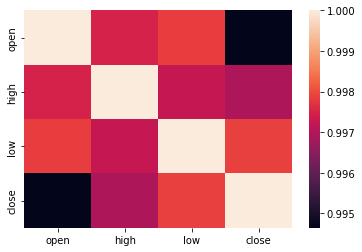

In [215]:
plt.figure(figsize=(30,5), dpi=80)
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Exchange Rate")
plt.plot(currency_df['date'], currency_df['open'], color='green', label='Open')
plt.plot(currency_df['date'], currency_df['close'], color='yellow', label='Close')
plt.plot(currency_df['date'], currency_df['high'], color='red', label='High')
plt.plot(currency_df['date'], currency_df['low'], color='blue', label='Low')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

print(currency_df.corr())
sns.heatmap(currency_df.corr())
plt.show()

In [216]:
x = currency_df[["open", "high", "low"]].to_numpy()
y = currency_df["close"].to_numpy().reshape(-1, 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

## 2. Data Analysis

### Applying Decision Tree Regression model
- Trained the model using training data
- Predicted results using testing data
- Identified score of predicted results vs actual result
- Plotted predicted and actual results to see the relationship between them

In [217]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(xtrain, ytrain)
dtr_y_pred = dtr_model.predict(xtest)

pred_data_decision_tree = pd.DataFrame(data={"Predicted Rate": dtr_y_pred.flatten()})
print("Score of the Decision Tree Regressor Model: ", dtr_model.score(xtest, ytest)*100)

Score of the Decision Tree Regressor Model:  99.01954592701964


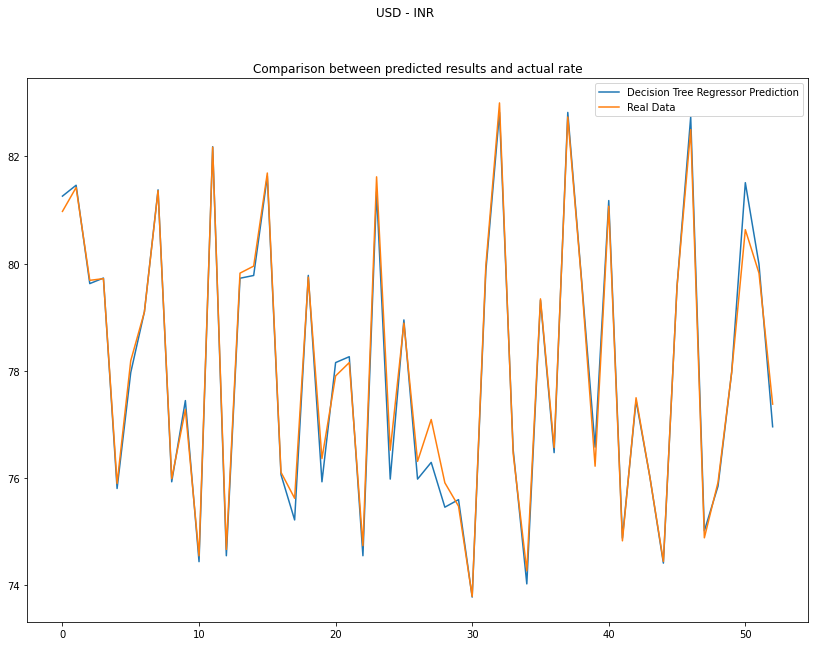

In [218]:
plt.figure(figsize=(14, 10))
plt.plot(dtr_y_pred, label = "Decision Tree Regressor Prediction")
plt.plot(ytest, label = "Real Data")
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Comparison between predicted results and actual rate")
plt.legend()
plt.show()

### 2. Applying MLP (multilayer perceptron) neural network
- Trained the model using training data
- Predicted results using testing data
- Identified score of predicted results vs actual result
- Plotted predicted and actual results to see the relationship between them

In [219]:
mlp_model = MLPRegressor(activation='relu', max_iter = 4000, alpha = 100, hidden_layer_sizes=50, random_state=3, 
                   learning_rate_init=0.001, learning_rate='adaptive')

mlp_model.fit(xtrain, ytrain.flatten())
mlp_y_pred = mlp_model.predict(xtest)
print("Score of the MLP Model: ", mlp_model.score(xtest, ytest) * 100)

Score of the MLP Model:  98.58719414165327


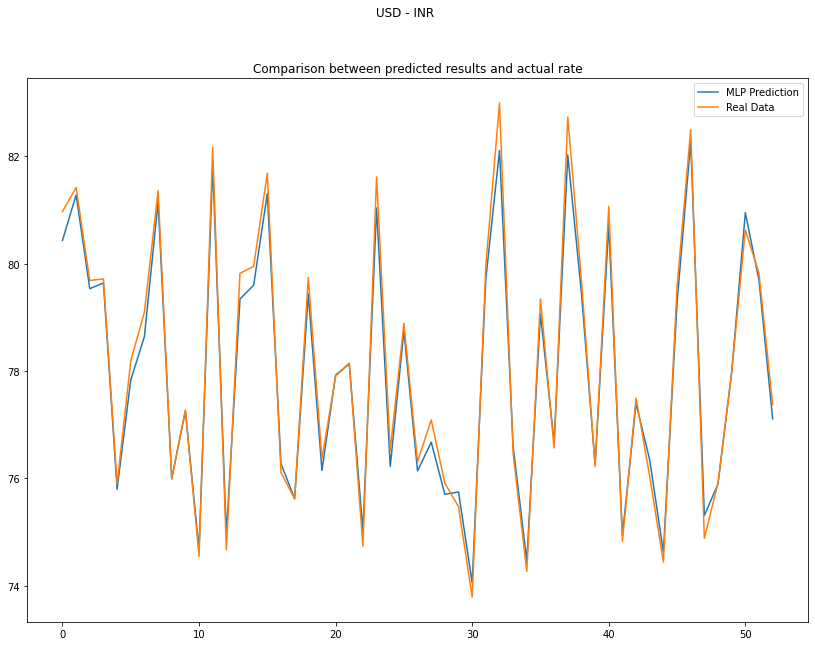

In [220]:
plt.figure(figsize=(14, 10))
plt.plot(mlp_y_pred, label = "MLP Prediction")
plt.plot(ytest, label = "Real Data")
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Comparison between predicted results and actual rate")
plt.legend()
plt.show()

### Applying forecasting using Prophet model
- Extract timeseries data i.e 'ds' using 'date' and target i.e. 'y' as 'close' from currency dataframe
- We use this data to fit into prophet model
- We create future dataframe for next 90 days and forecast the closing rates using this model

In [221]:
# Prophet model requires a timeseries field (ds) and target(y) to forecast, 
# hence we extract date & close rates from currency dataframe
prophet_dataset = pd.DataFrame()
prophet_dataset['ds'] = pd.to_datetime(currency_df["date"])
prophet_dataset['y'] = pd.to_numeric(currency_df['close'])
prophet_dataset

,ds,y
0,2021-12-01,75.00900
1,2021-12-02,74.97580
2,2021-12-03,75.32664
3,2021-12-06,75.39134
4,2021-12-07,75.43165
...,...,...
257,2022-11-25,81.69398
258,2022-11-28,81.63102
259,2022-11-29,81.61402
260,2022-11-30,81.36195


In [222]:
# Fitting date and close rates in prophet model
prophet_basic = Prophet()
prophet_basic.fit(prophet_dataset)

# create timeseries dataframe including future dates
future_df = prophet_basic.make_future_dataframe(periods=90)
future_df

01:10:53 - cmdstanpy - INFO - Chain [1] start processing
01:10:53 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2021-12-01
1,2021-12-02
2,2021-12-03
3,2021-12-06
4,2021-12-07
...,...
347,2023-02-25
348,2023-02-26
349,2023-02-27
350,2023-02-28


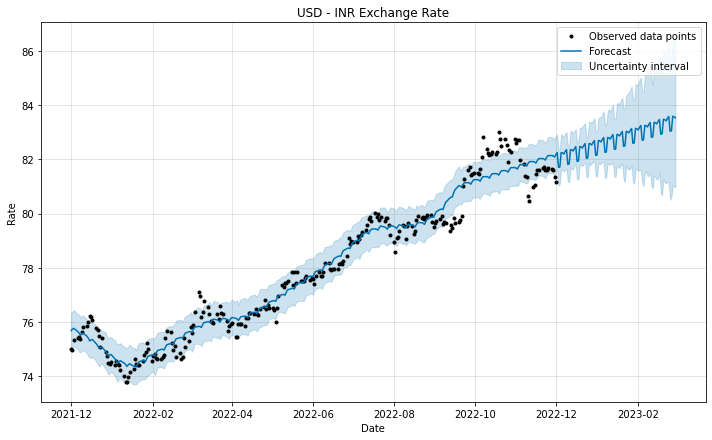

In [223]:
#predicting/forecasting close rates for future dates
forecast = prophet_basic.predict(future_df)
prophet_basic.plot(forecast)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

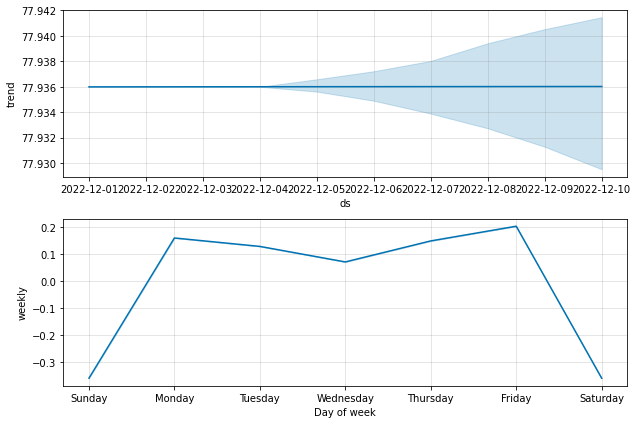

In [232]:
prophet_basic.plot_components(forecast)
plt.show()

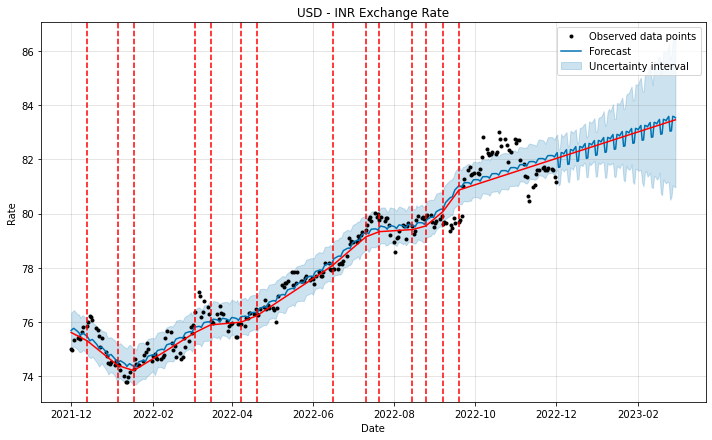

In [225]:
#Plotting forecasted results with changepoints
fig = prophet_basic.plot(forecast)
add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


**Observation:** 
Changepoints helps us to understand the changing trends and their relevant dates

In [226]:
pd.DataFrame(prophet_basic.changepoints)

,ds
8,2021-12-13
17,2021-12-24
25,2022-01-05
33,2022-01-17
42,2022-01-28
50,2022-02-09
58,2022-02-21
67,2022-03-04
75,2022-03-16
83,2022-03-28


## Data Evaluation

As "Prophet" model is able to forecast currency prediction for future dates, let us try to evaluate our results further to strengthen above analysis

By default proportion of history in which trend changepoints will be estimated is 80%, we can tweak that 90 and see the change in prediction

01:10:56 - cmdstanpy - INFO - Chain [1] start processing
01:10:56 - cmdstanpy - INFO - Chain [1] done processing


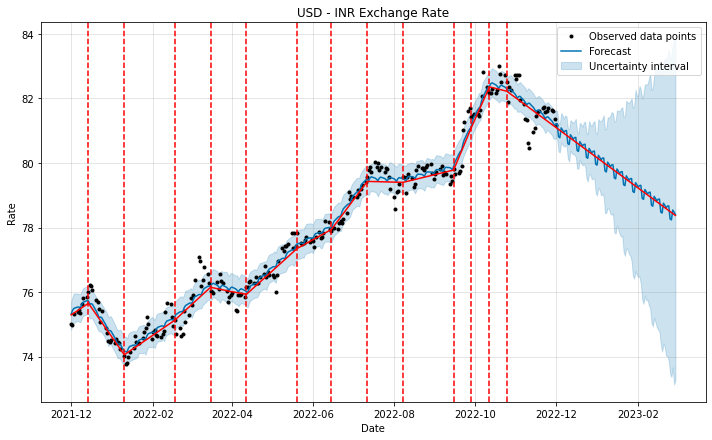

In [227]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(prophet_dataset).predict(future_df)
fig= pro_change.plot(forecast)
add_changepoints_to_plot(fig.gca(), pro_change, forecast)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

As it appears there's a downwards trend for the future dates as compared to previous example due to change in changepoints range. This could mean that through more proportion of history in which trend changepoints are estimated, the results would vary. Since this is futuristic data, we couldn't be 100% sure, however we can try strengthening our model.

Hence we would need to add some features as regressor to train the model for better forecasting accuracy.

In [228]:
# setting up a new dataframe for regressor
currency_df_for_regressor = pd.DataFrame()
currency_df_for_regressor['ds'] = currency_df['date']
currency_df_for_regressor['y'] = currency_df['close']
currency_df_for_regressor['open'] = currency_df['open']
currency_df_for_regressor['high'] = currency_df['high']
currency_df_for_regressor['low'] = currency_df['low']

train, test = train_test_split(currency_df_for_regressor, test_size=0.3)



01:49:40 - cmdstanpy - INFO - Chain [1] start processing
01:49:40 - cmdstanpy - INFO - Chain [1] done processing


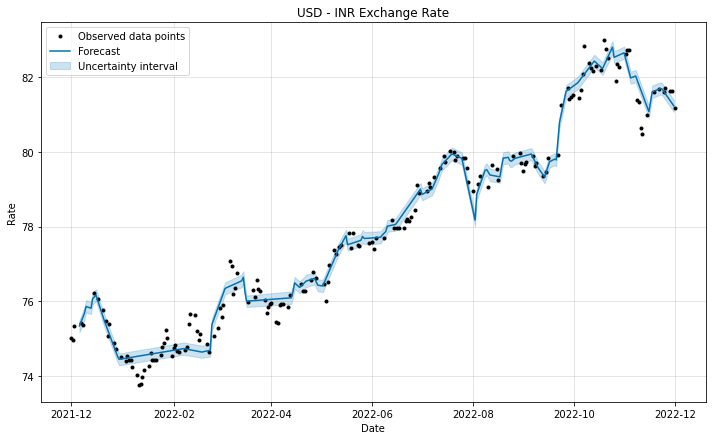

In [266]:

#Additional Regressor
pro_regressor = Prophet()
pro_regressor.add_regressor('open')
pro_regressor.add_regressor('high')
pro_regressor.add_regressor('low')

#Fitting the data
pro_regressor.fit(train)
future_data = pro_regressor.make_future_dataframe(periods=90)

#forecast the data for Test data
forecast_data = pro_regressor.predict(test)
pro_regressor.plot(forecast_data, uncertainty=True)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


Here we were able to train and test data using prophet model where features `open`, `high`, `low` was used as a regressor. Now we'll try to predict future based on random outcomes of open values for the next 10 days.

In [267]:
days = 10
future_range = pd.date_range(end_date, periods=days, freq='D')
future_df = pd.DataFrame({ 'ds': future_range})

def find_estimate_range(df, feature):
    first = currency_df[-10:][feature].median()
    second = currency_df[-60:][feature].median()
    if first < second:
        return first, second
    else:
        return second, first


for feature in ['open', 'high', 'low']:
    start_estimate_range, end_estimate_range = find_estimate_range(currency_df, feature)
    for i in range (0, days):
        future_df.at[i, feature] = random.uniform(start_estimate_range, end_estimate_range)

future_df

,ds,open,high,low
0,2022-12-01,81.6315,81.803308,81.518168
1,2022-12-02,81.6315,81.795498,81.485908
2,2022-12-03,81.6315,81.833132,81.526706
3,2022-12-04,81.6315,81.804858,81.489439
4,2022-12-05,81.6315,81.854207,81.507479
5,2022-12-06,81.6315,81.871327,81.531375
6,2022-12-07,81.6315,81.818419,81.509500
7,2022-12-08,81.6315,81.872450,81.488021
8,2022-12-09,81.6315,81.873754,81.524979
9,2022-12-10,81.6315,81.812054,81.512728


Using above created data by using random values of `open`, `high`, `low` based on range of median between last 10 and 60 days we will try forecasting close rates

01:49:55 - cmdstanpy - INFO - Chain [1] start processing
01:49:55 - cmdstanpy - INFO - Chain [1] done processing


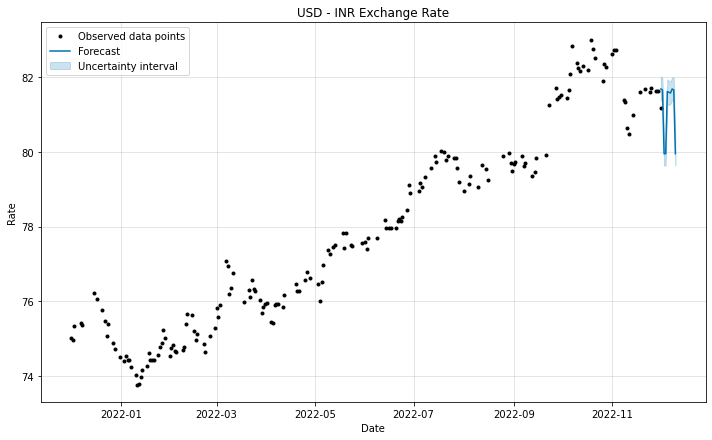

In [269]:
new_df = pd.DataFrame()
new_df['ds'] = pd.to_datetime(currency_df["date"])
new_df['y'] = pd.to_numeric(currency_df['close'])
new_df['open'] = pd.to_numeric(currency_df['open'])


m = Prophet()
m.add_regressor('open')
m.fit(new_df)
forecast = m.predict(future_df)
pro_regressor.plot(forecast, uncertainty=True, include_legend=True)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


Hence we're able to forecast rates using features `open`, `high`, `low` as a regressor in prophet model. Thus we're able to predict rates and with stronger analysis of identifying feature values we would be able to achieve higher accuracy

## Conclusion
We tried to apply 3 models for analysing and predicting currencies
1. Decision Tree Regressor
2. MLP
3. Prophet

- The first two models helped in analysing the data, understand the linearity and relationship of features like 'Open', 'High', 'Low' values
- The data didn't have any noise thus we could notice moving trends
- Since the data is based on timeseries, i.e. the target value 'close' varies based on dates we applied Prophet to evaluate result on timeseries.
- Using this we added above features as regressor and tried predicting rates for the future which could have a higher accuracy.
- This project supports predicting exchange rates for varying currencies with flexible time range.



## References:
- https://www.earnforex.com/guides/high-low-vs-open-close/
- https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda
- https://www.sciencedirect.com/topics/computer-science/multilayer-perceptron
- https://facebook.github.io/prophet/
